# Capstone Project Notebook

In [4]:
# import preliminary libraries etc
import numpy as np 
import pandas as pd
import json
import seaborn as sns
import wikipedia as wp
import matplotlib.pyplot as plt
%matplotlib inline

!pip install geopy
import io
import requests


import folium
from sklearn.cluster import KMeans

from geopy.geocoders import Nominatim


import matplotlib.cm as cm
import matplotlib.colors as colors

     |████████████████████████████████| 122kB 6.0MB/s eta 0:00:01


In [5]:
# install to read from wiki
!pip install wikipedia

In [6]:
# Obtain the page information
html = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")
df_tor = pd.read_html(html)[0]

#Delete rows where borough is not assigned
df_tor = df_tor[df_tor['Borough'] != 'Not assigned']

# change column names
column_names = ['PostalCode','Borough', 'Neighborhood'] 
df_tor.columns = column_names
df_tor.head(2)

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village


In [9]:
#Combine all neighborhoods where postcode and borough are the same
df_tor = df_tor.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()

# reset the index
df_tor.reset_index()

# view the table, viewing more rows shows distinct postal codes
df_tor.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [10]:
df_tor.dropna(subset=['Borough'], inplace=True)

In [11]:
n_empty_neighborhood = df_tor[df_tor['Neighborhood'].isna()].shape[0]
print('Number of rows on which Neighborhood column is empty: {}'.format(n_empty_neighborhood))

Number of rows on which Neighborhood column is empty: 0


In [12]:
df_torp = df_tor.groupby(['PostalCode','Borough']).Neighborhood.agg([('Neighborhood', ', '.join)])
df_torp.reset_index(inplace=True)
df_torp.head(5)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [13]:
print('The shape of the dataset is:',df_torp.shape)

The shape of the dataset is: (103, 3)


In [14]:
df_torp.to_csv('Tor_Zips.csv')

In [15]:
# add in longitude and latitude of postal codes
url="https://cocl.us/Geospatial_data"
s=requests.get(url).content
c=pd.read_csv(io.StringIO(s.decode('utf-8')))

# join location parameters to original dataset
df_torl = df_torp.join(c.set_index('Postal Code'), on='PostalCode')
df_torl.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [16]:
df_torl.to_csv('Tor_Zip2.csv')

In [17]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df_torl['Borough'].unique()),
        df_torl.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


In [18]:
#count Bourough and Neighborhood
df_torl.groupby('Borough').count()['Neighborhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Scarborough         17
West Toronto         6
York                 5
Name: Neighborhood, dtype: int64

In [19]:
address = 'Toronto'
# initialize variables to create folium map
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [20]:
# create map of New York using latitude and longitude values
map_tor = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_torl['Latitude'], df_torl['Longitude'], df_torl['Borough'], df_torl['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tor)  
# show toronto map overlayed with neighborhoods
map_tor

In [21]:
# API information
LIMIT = 100
#radius = 500
CLIENT_ID = 'TEH5ULXANVFVXKVOT5ZUU1EUIXUCXF2BPQLUIIN33IK0JXDP' 
CLIENT_SECRET = 'TL4GM2GSEC0BLRZAIVP40BMUHZ54KENBWK31OOBOGBIGZERQ' 
VERSION = '20180605' 

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: TEH5ULXANVFVXKVOT5ZUU1EUIXUCXF2BPQLUIIN33IK0JXDP
CLIENT_SECRET:TL4GM2GSEC0BLRZAIVP40BMUHZ54KENBWK31OOBOGBIGZERQ


In [22]:
# define function getNearbyVenues
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
       
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
# Toronto venues using defined function
tor_venues = getNearbyVenues(names=df_torl['Neighborhood'],
                                   latitudes=df_torl['Latitude'],
                                   longitudes=df_torl['Longitude'],
                                  );

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [26]:
tor_venues.shape

(2130, 7)

In [27]:
tor_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant


In [28]:
tor_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
...,...,...,...,...,...,...
"Willowdale, Willowdale West",6,6,6,6,6,6
Woburn,3,3,3,3,3,3
Woodbine Heights,6,6,6,6,6,6


In [29]:
print('There are {} unique categories.'.format(len(tor_venues['Venue Category'].unique())))

There are 272 unique categories.


In [30]:
tor_venues['Venue Category'].unique()[:100]

array(['Fast Food Restaurant', 'Bar', 'Bank', 'Electronics Store',
       'Mexican Restaurant', 'Rental Car Location', 'Medical Center',
       'Intersection', 'Breakfast Spot', 'Coffee Shop',
       'Korean Restaurant', 'Hakka Restaurant', 'Caribbean Restaurant',
       'Thai Restaurant', 'Athletics & Sports', 'Bakery', 'Gas Station',
       'Fried Chicken Joint', 'Playground', 'Grocery Store',
       'Convenience Store', 'Department Store', 'Chinese Restaurant',
       'Train Station', 'Bus Station', 'Ice Cream Shop', 'Metro Station',
       'Bus Line', 'Park', 'Soccer Field', 'Motel', 'American Restaurant',
       'Café', 'General Entertainment', 'Farm', 'Skating Rink',
       'College Stadium', 'Indian Restaurant', 'Pet Store',
       'Vietnamese Restaurant', 'Light Rail Station', 'Gaming Cafe',
       'Sandwich Place', 'Middle Eastern Restaurant', 'Auto Garage',
       'Lounge', 'Latin American Restaurant', 'Clothing Store',
       'Italian Restaurant', 'Noodle House', 'Pizza Plac

In [31]:
# check if the results contain "Indian Restaurants"

"Indian Restaurant" in tor_venues['Venue Category'].unique()

True

In [32]:
# one hot encoding
tor_onehot = pd.get_dummies(tor_venues[['Venue Category']], prefix="", prefix_sep="")

tor_onehot['Neighborhoods'] = tor_venues['Neighborhood'] 

fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[fixed_columns]

#print(tor_onehot.shape)
#tor_onehot.head()

In [33]:
tor_group = tor_onehot.groupby(["Neighborhoods"]).mean().reset_index()
tor_group.head()

,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043478,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
len(tor_group[tor_group["Indian Restaurant"] > 0])

10

In [35]:
indian_neighbor = tor_group[["Neighborhoods","Indian Restaurant"]]

In [36]:
indian_neighbor.head()

,Neighborhoods,Indian Restaurant
0,Agincourt,0.000000
1,"Alderwood, Long Branch",0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.000000
3,Bayview Village,0.000000
4,"Bedford Park, Lawrence Manor East",0.043478


In [37]:
toclusters = 3

to_clustering = indian_neighbor.drop(["Neighborhoods"], 1)

kmeans = KMeans(n_clusters=toclusters, random_state=0).fit(to_clustering)

kmeans.labels_[0:10]

array([0, 0, 0, 0, 2, 0, 0, 0, 0, 0], dtype=int32)

In [38]:
tor_merge = indian_neighbor.copy()

tor_merge["Cluster Labels"] = kmeans.labels_

In [39]:
tor_merge = tor_merge.join(tor_venues.set_index("Neighborhood"), on="Neighborhoods")

print(tor_merge.shape)
tor_merge.head()

(2130, 9)


,Neighborhoods,Indian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agincourt,0.0,0,43.7942,-79.262029,Panagio's Breakfast & Lunch,43.792370,-79.260203,Breakfast Spot
0,Agincourt,0.0,0,43.7942,-79.262029,Twilight,43.791999,-79.258584,Lounge
0,Agincourt,0.0,0,43.7942,-79.262029,El Pulgarcito,43.792648,-79.259208,Latin American Restaurant
0,Agincourt,0.0,0,43.7942,-79.262029,Mark's,43.791179,-79.259714,Clothing Store
0,Agincourt,0.0,0,43.7942,-79.262029,Commander Arena,43.794867,-79.267989,Skating Rink


In [40]:
print(tor_merge.shape)
tor_merge.sort_values(["Cluster Labels"], inplace=True)

(2130, 9)


In [41]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(toclusters)
ys = [i+x+(i*x)**2 for i in range(toclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(tor_merge['Neighborhood Latitude'], tor_merge['Neighborhood Longitude'], tor_merge['Neighborhoods'], tor_merge['Cluster Labels']):
    #label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup='label',
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

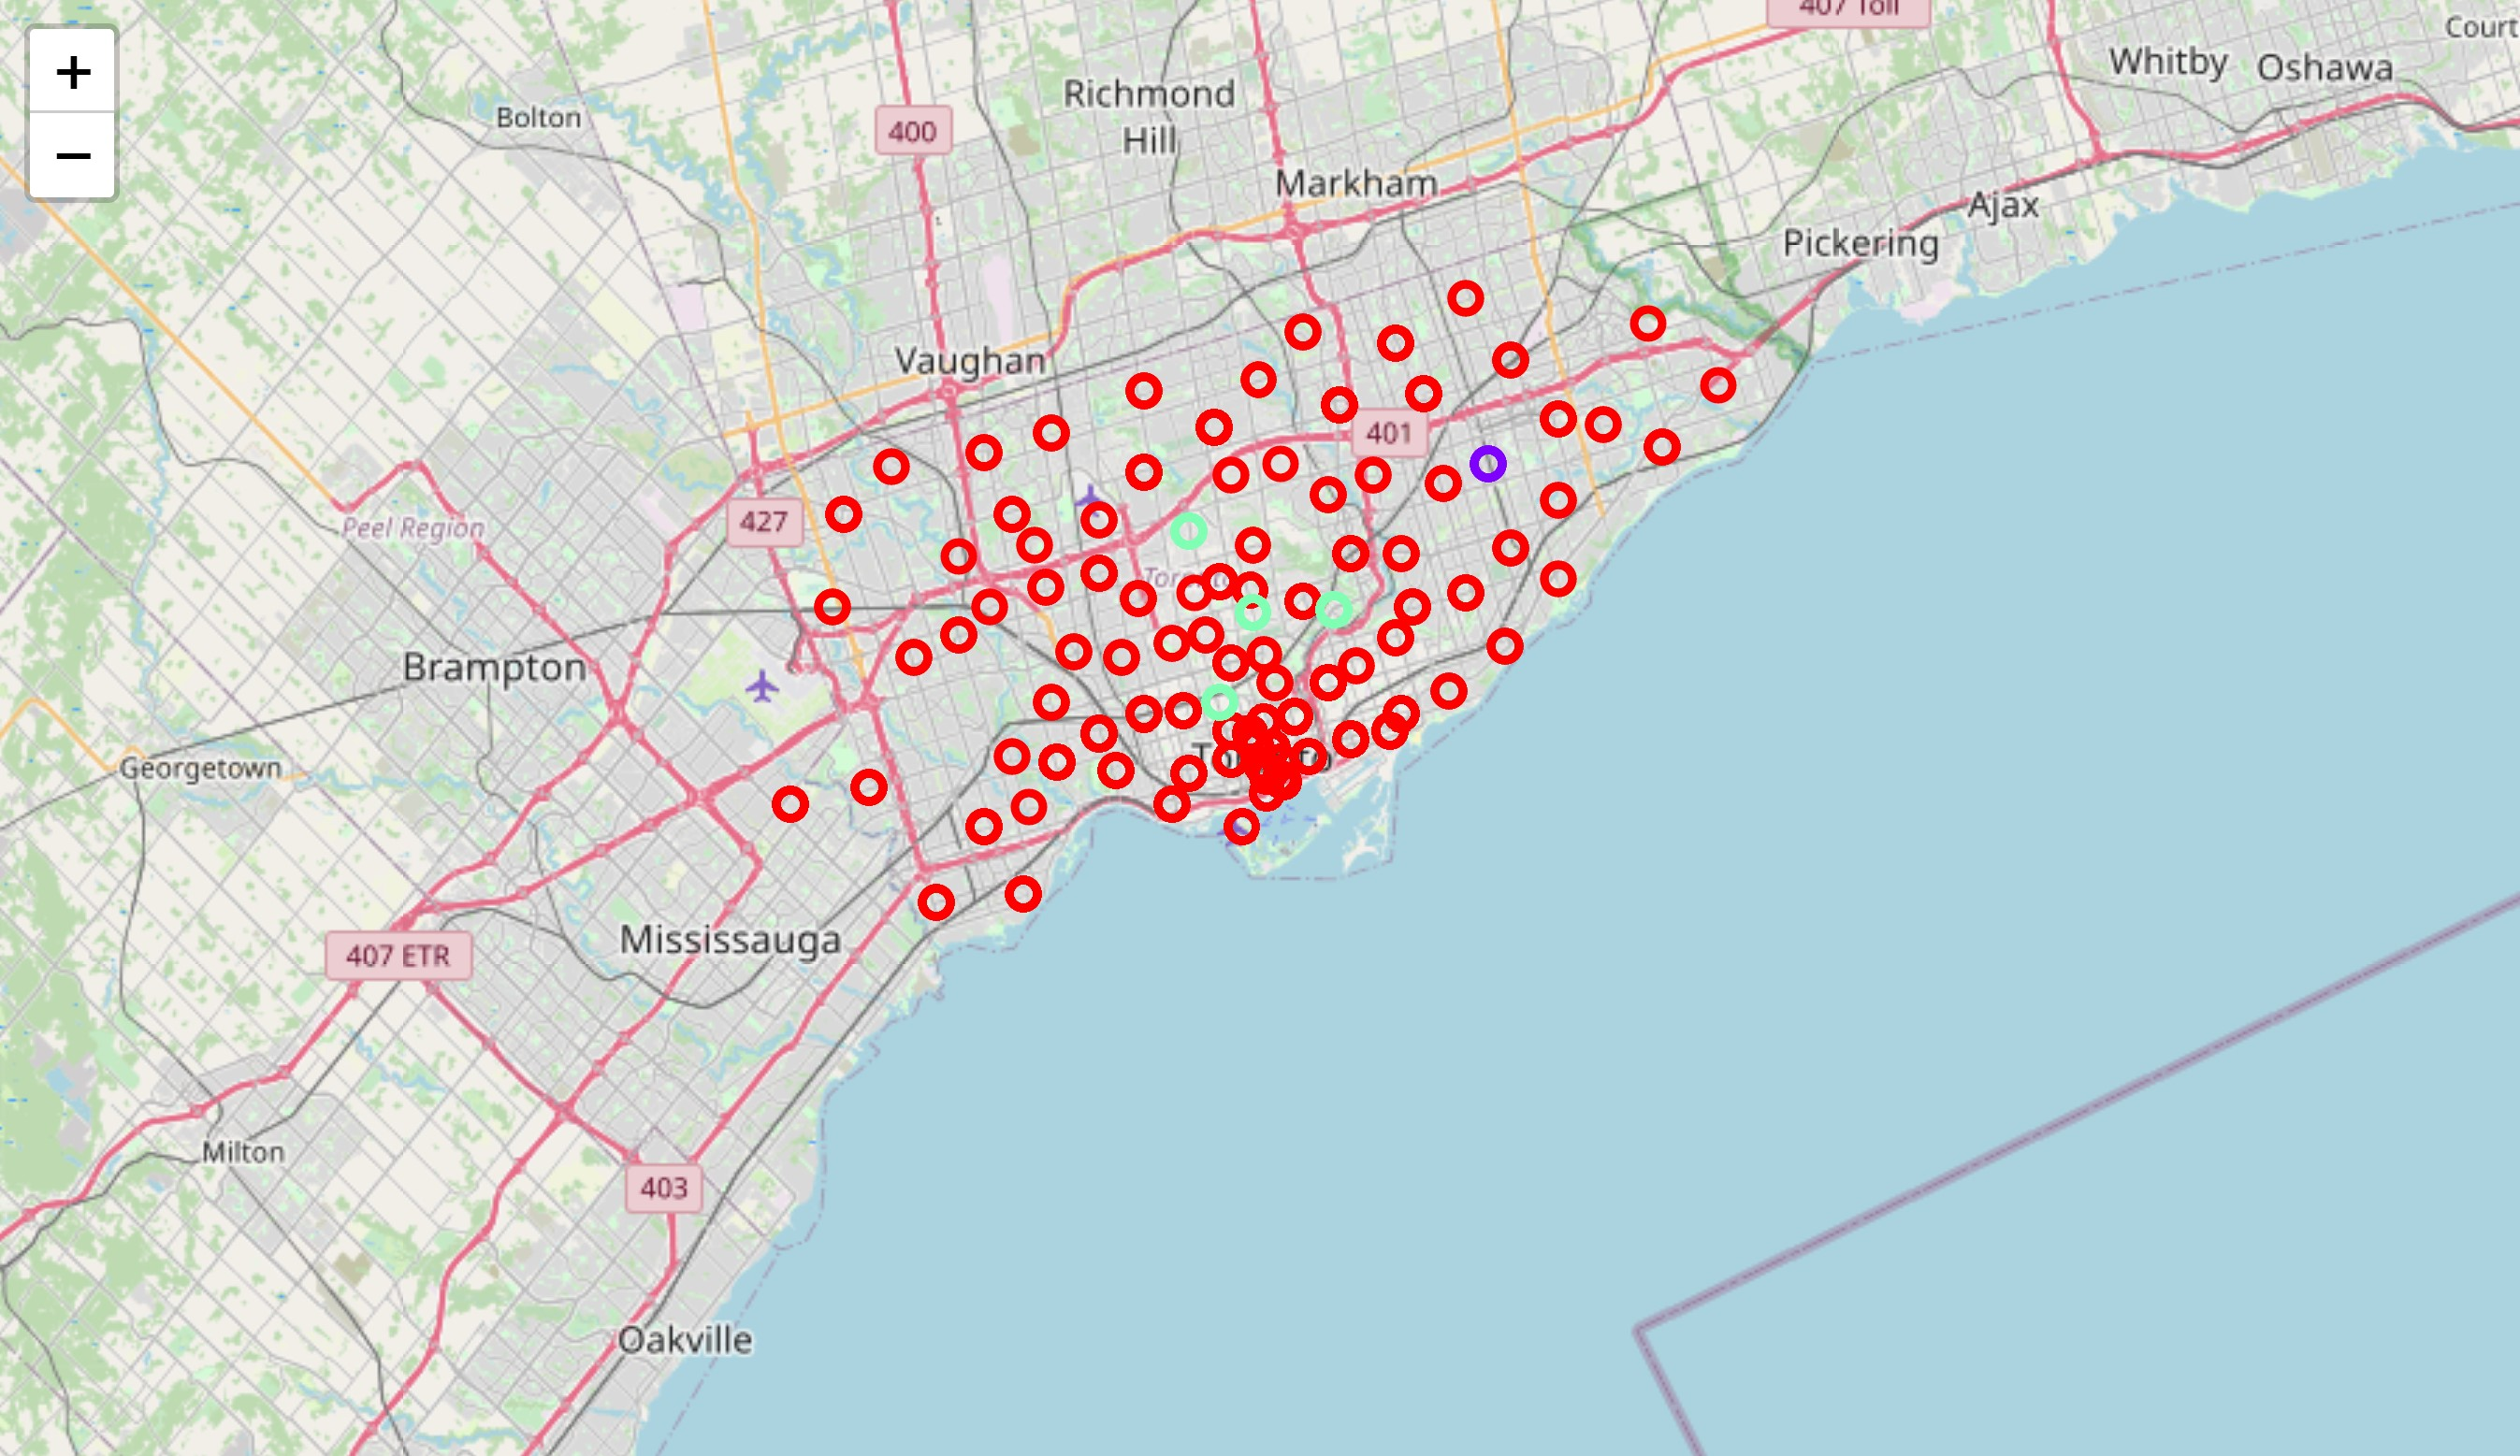

In [44]:
# image displaying map above
from IPython.display import Image
Image("folium.jpg")

In [83]:
tor_merge.groupby('Cluster Labels').mean()

,Indian Restaurant,Neighborhood Latitude,Neighborhood Longitude,Venue Latitude,Venue Longitude
Cluster Labels,,,,,
0,0.002470,43.672513,-79.388647,43.672555,-79.388590
1,0.285714,43.757410,-79.273304,43.756066,-79.276450
2,0.050505,43.704578,-79.390806,43.705327,-79.390727


In [88]:
map_clusters.save('map_clusters.html')

In [94]:
tor_merge.groupby('Neighborhoods').count()

,Indian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhoods,,,,,,,,
Agincourt,5,5,5,5,5,5,5,5
"Alderwood, Long Branch",8,8,8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",20,20,20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23,23,23
...,...,...,...,...,...,...,...,...
"Willowdale, Willowdale West",6,6,6,6,6,6,6,6
Woburn,3,3,3,3,3,3,3,3
Woodbine Heights,6,6,6,6,6,6,6,6


#### Examine clusters in depth

In [ ]:
tor_merge.loc[tor_merge['Cluster Labels'] == 0]

In [ ]:
tor_merge.loc[tor_merge['Cluster Labels'] == 1]

In [92]:
tor_merge.loc[tor_merge['Cluster Labels'] == 2]

,Neighborhoods,Indian Restaurant,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
82,Thorncliffe Park,0.090909,2,43.705369,-79.349372,Hero Certified Burgers,43.705511,-79.347064,Burger Joint
82,Thorncliffe Park,0.090909,2,43.705369,-79.349372,A&W,43.706275,-79.344670,Fast Food Restaurant
82,Thorncliffe Park,0.090909,2,43.705369,-79.349372,Tim Hortons,43.705090,-79.350545,Coffee Shop
82,Thorncliffe Park,0.090909,2,43.705369,-79.349372,Petro-Canada,43.704058,-79.348094,Gas Station
82,Thorncliffe Park,0.090909,2,43.705369,-79.349372,Hakka Garden,43.704578,-79.349770,Indian Restaurant
...,...,...,...,...,...,...,...,...,...
19,Davisville,0.030303,2,43.704324,-79.388790,Positano,43.704558,-79.388639,Italian Restaurant
19,Davisville,0.030303,2,43.704324,-79.388790,Flaky Tart,43.706539,-79.389611,Dessert Shop
19,Davisville,0.030303,2,43.704324,-79.388790,Thai Spicy House,43.701962,-79.387513,Thai Restaurant
19,Davisville,0.030303,2,43.704324,-79.388790,Marigold Indian Bistro,43.702881,-79.388008,Indian Restaurant


In [42]:
# create map
map1_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(toclusters)
ys = [i+x+(i*x)**2 for i in range(toclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(tor_merge['Neighborhood Latitude'], tor_merge['Neighborhood Longitude'], tor_merge['Neighborhoods'], tor_merge['Cluster Labels']):
    #label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup='label',
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
folium.Marker([43.672513, -79.388647], popup='Cluster 0').add_to(map1_clusters)
folium.Marker([43.757410, -79.273304], popup='Cluster 1').add_to(map1_clusters)    
folium.Marker([43.704578, -79.390806], popup='Cluster 2').add_to(map1_clusters) 

map1_clusters


